### American Sign Language

American Sign Language (ASL) is a complete, complex language that employs signs made by moving the
hands combined with facial expressions and postures of the body. It is the primary language of many
North Americans who are deaf and is one of several communication options used by people who are deaf or
hard-of-hearing.

The hand gestures representing English alphabet are shown below. This project focuses on classifying a subset
of these hand gesture images using convolutional neural networks. Specifically, given an image of a hand
showing one of the letters A-I, we want to detect which letter is being represented.

![alt text](https://www.disabled-world.com/pics/1/asl-alphabet.jpg)

# Building a CNN

### Part 1. Data Loading and Splitting

In [ ]:
import torch 
torch.manual_seed(1517) 
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import warnings
warnings.filterwarnings("ignore")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/Project_Gesture_Dataset'

transform = T.Compose([T.Resize((224,224)),T.ToTensor()])

complete_data = torchvision.datasets.ImageFolder(path, transform=transform)

In [ ]:
def class_dist(data):
  labels = []
  for img, lab in data:
    labels.append(int(lab))

  dist = sorted(dict(Counter(labels)).items())
  return dist

In [ ]:
total_dist = class_dist(complete_data)
print('Class distribution of complete data with {} samples: {}'.format(len(complete_data),total_dist))

Class distribution of complete data with 2431 samples: [(0, 272), (1, 273), (2, 273), (3, 273), (4, 272), (5, 273), (6, 273), (7, 273), (8, 249)]


In [ ]:
#manually splitting the data into 60 percentage - Train, 20 percentage - Validation, 20 percetage - Test
val_start, test_start = int(len(complete_data)*0.6), int(len(complete_data)*0.8)

index = np.arange(len(complete_data))
np.random.seed(1517)#to reproduce results
np.random.shuffle(index)

train_index, val_index, test_index = index[:val_start], index[val_start:test_start], index[test_start:]

train_sampler = SubsetRandomSampler(train_index)
val_sampler   = SubsetRandomSampler(val_index)
test_sampler  = SubsetRandomSampler(test_index)

def get_data(batch_size):

  train_loader  = torch.utils.data.DataLoader(complete_data, batch_size=batch_size, num_workers=1, sampler=train_sampler)
  val_loader    = torch.utils.data.DataLoader(complete_data, batch_size=batch_size, num_workers=1, sampler=val_sampler)
  test_loader   = torch.utils.data.DataLoader(complete_data, batch_size=batch_size, num_workers=1, sampler=test_sampler)

  return train_loader, val_loader, test_loader

In [ ]:
#keeping batch size as 1 to get the class distribution count
train_loader, val_loader, test_loader = get_data(batch_size=1)

train_dist = class_dist(train_loader)
val_dist = class_dist(val_loader)
test_dist = class_dist(test_loader)

print('Class distribution of Train data with {} samples: {}'.format(len(train_loader),train_dist))
print('Class distribution of Validation data with {} samples: {}'.format(len(val_loader),val_dist))
print('Class distribution of Test data with {} samples: {}'.format(len(test_loader),test_dist))

Class distribution of Train data with 1458 samples: [(0, 173), (1, 149), (2, 158), (3, 156), (4, 160), (5, 164), (6, 174), (7, 177), (8, 147)]
Class distribution of Validation data with 486 samples: [(0, 48), (1, 56), (2, 61), (3, 55), (4, 64), (5, 53), (6, 55), (7, 49), (8, 45)]
Class distribution of Test data with 487 samples: [(0, 51), (1, 68), (2, 54), (3, 62), (4, 48), (5, 56), (6, 44), (7, 47), (8, 57)]


In [ ]:
train_loader, val_loader, test_loader = get_data(batch_size=32)
target_class = ['A','B','C','D','E','F','G','H','I']

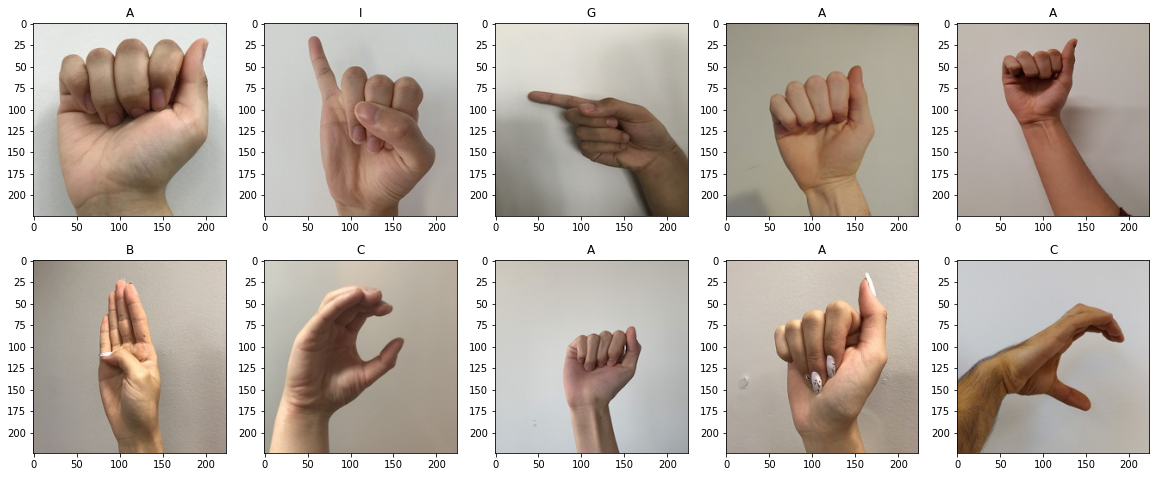

In [ ]:
#visualizing the 10 train data samples
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20,8))

i=0
for row in ax:
    for col in row:
        col.imshow(np.transpose(images[i], (1, 2, 0)))
        col.set_title(target_class[labels[i]])
        i = i+1

plt.show()


The given dataset Project_Gesture_Dataset was uploaded to google drive and it's read using torchvision.datasets.ImageFolder with (224 x 224) transformation applied. I am considering 60 percent of data for training, 20 percent for validation, and 20 percentage for testing. For splitting the data, I am using SubsetRandomSampler by passing the shuffled index.

### Part 2. Model Building and Sanity Checking

### Part (a) Convolutional Network

For my convolutional neural network model, I have chosen 3 convolutional layers which were better than 2 convolutional layers as per the metrics. I have used 3 max-pooling layers after the convolutional layers to decrease of the image dimensions and help in image classification. I am using RELU as a hidden layer activation function which is most commonly used for image classification.<br>
After passing the image through three hidden convolutional layers, I had flattened the image and found the input channels count, and then again passed it to the two linear layers for image classification. I have also applied a RELU activation between the linear layers.

In [ ]:
#to handle the internal errors
def error_handling(e):
        print('\n\n========== ERROR ==========\n\n')
        print('Error type: {}\nError Description: {}\nError line number: {}\n'.format(
        type(e).__name__,           # Error type
        e,                          # Error Text
        e.__traceback__.tb_lineno,  # Error line
        ))

In [ ]:
#Convolutional Neural Network Architecture
class HandGestureClassifier(nn.Module):
    def __init__(self):
        super(HandGestureClassifier, self).__init__()
        try:
          self.name = 'HandGestureClassifier'
          self.conv1 = nn.Conv2d(3, 16, 5) #in_channels, out_chanels, kernel_size
          self.pool1 = nn.MaxPool2d(2, 2) #kernel_size, stride 
          self.conv2 = nn.Conv2d(16, 32, 5) #in_channels, out_chanels, kernel_size
          self.pool2 = nn.MaxPool2d(2, 2) #kernel_size, stride
          self.conv3 = nn.Conv2d(32, 64, 5) #in_channels, out_chanels, kernel_size
          self.pool3 = nn.MaxPool2d(2, 2) #kernel_size, stride
          self.flat = nn.Flatten()
          self.fc1 = nn.Linear(36864, 32)
          self.fc2 = nn.Linear(32, 9)

        except Exception as e:
          error_handling(e)

    def forward(self, x):
        try:

          x = self.pool1(F.relu(self.conv1(x)))
          x = self.pool2(F.relu(self.conv2(x)))
          x = self.pool3(F.relu(self.conv3(x)))
          x = self.flat(x)
          # print(x.size()) #found in_features size by printing the size of flatten
          x = F.relu(self.fc1(x))
          x = self.fc2(x)

        except Exception as e:
          error_handling(e)

        return x

### Part (b) Training Code

The given problem is multiclass classification, so I am using CrossEntropyLoss as the loss function and using Adam optimizer as it is the best optimizer for multiclass classification and also it takes fewer epochs to reach the optimal cost value.

In [ ]:
def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    try:
      for imgs, labels in data_loader:
          
          
          #############################################
          #To Enable GPU Usage
          if use_cuda and torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()
          #############################################
          
          
          output = model(imgs)
          
          #select index with maximum prediction score
          pred = output.max(1, keepdim=True)[1]
          correct += pred.eq(labels.view_as(pred)).sum().item()
          total += imgs.shape[0]
          
    except Exception as e:
          error_handling(e)

    return correct / total


In [ ]:
def get_model_name(name, batch_size, learning_rate, epoch):

    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name, batch_size, learning_rate, epoch)
    return path

In [ ]:
def train(model, learning_rate=0.01, batch_size=64, num_epochs=20):
    
    try:
      start = datetime.now()
      criterion = nn.CrossEntropyLoss()
      optimizer = optim.Adam(model.parameters(), lr=learning_rate)

      train_loader, val_loader, test_loader = get_data(batch_size=batch_size)

      iters, losses, train_acc, val_acc = [], [], [], []
      t_acc, v_acc = 0, 0

      # training
      n = 0 # the number of iterations
      for epoch in range(num_epochs):
          for imgs, labels in iter(train_loader):
            
            
              #############################################
              #To Enable GPU Usage
              if use_cuda and torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()
              #############################################
              
                
              out = model(imgs)             # forward pass
              loss = criterion(out, labels) # compute the total loss
              loss.backward()               # backward pass (compute parameter updates)
              optimizer.step()              # make the updates for each parameter
              optimizer.zero_grad()         # a clean up step for PyTorch

              # save the current training information
              iters.append(n)
              losses.append(float(loss)/batch_size)             # compute *average* loss
              t_acc = get_accuracy(model, train_loader)
              v_acc = get_accuracy(model, val_loader)
              train_acc.append(t_acc) # compute training accuracy 
              val_acc.append(v_acc)  # compute validation accuracy
              n += 1
          
          model_path = get_model_name(model.name, batch_size, learning_rate, epoch+1)
          torch.save(model.state_dict(), model_path)

          print(("Epoch : {}, Train Accuracy: {}, Test Accuracy: {}, Model path: {}").format(epoch+1, t_acc, v_acc, model_path))

      # plotting
      plt.title("Training Curve")
      plt.plot(iters, losses, label="Train")
      plt.xlabel("Iterations")
      plt.ylabel("Loss")
      plt.show()

      plt.title("Training Curve")
      plt.plot(iters, train_acc, label="Train")
      plt.plot(iters, val_acc, label="Validation")
      plt.xlabel("Iterations")
      plt.ylabel("Training Accuracy")
      plt.legend(loc='best')
      plt.show()

      print("Final Training Accuracy: {}".format(train_acc[-1]))
      print("Final Validation Accuracy: {}".format(val_acc[-1]))

      stop = datetime.now()
      runtime = stop - start
      print('Total run time for {}: {} (HH:MM:SS)'.format(model_path, runtime))

    except Exception as e:
          error_handling(e)
    

### Part (c) “Overfit” to a Small Dataset

One way to sanity check our neural network model and training code is to check whether the model is capable
of “overfitting” or “memorizing” a small dataset. A properly constructed CNN with correct training code
should be able to memorize the answers to a small number of images quickly.

In [ ]:
#created small loader with 20 batch size and 20 images
small_index   = index[:20]
small_sampler = SubsetRandomSampler(small_index)
small_loader  = torch.utils.data.DataLoader(complete_data, batch_size=20, num_workers=1, sampler=small_sampler)

In [ ]:
def train_small(model, learning_rate=0.001, batch_size=20, num_epochs=50):
    
    try:
      start = datetime.now()
      criterion = nn.CrossEntropyLoss()
      optimizer = optim.Adam(model.parameters(), lr=learning_rate)

      iters, losses, train_acc  = [], [], []
      t_acc = 0

      train_loader = small_loader

      # training
      n = 0 # the number of iterations
      for epoch in range(num_epochs):
          for imgs, labels in iter(train_loader):
            
            
              #############################################
              #To Enable GPU Usage
              if use_cuda and torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()
              #############################################
              
                
              out = model(imgs)             # forward pass
              loss = criterion(out, labels) # compute the total loss
              loss.backward()               # backward pass (compute parameter updates)
              optimizer.step()              # make the updates for each parameter
              optimizer.zero_grad()         # a clean up step for PyTorch

              # save the current training information
              iters.append(n)
              losses.append(float(loss)/batch_size)             # compute *average* loss
              t_acc = get_accuracy(model, train_loader)
              train_acc.append(t_acc) # compute training accuracy
              n += 1
          
          model_path = get_model_name(model.name, batch_size, learning_rate, epoch+1)
          torch.save(model.state_dict(), model_path)

          print(("Epoch : {}, Train Accuracy: {}, Model path: {}").format(epoch+1, t_acc, model_path))

      # plotting
      plt.title("Training Curve")
      plt.plot(iters, losses, label="Train")
      plt.xlabel("Iterations")
      plt.ylabel("Loss")
      plt.show()

      plt.title("Training Curve")
      plt.plot(iters, train_acc, label="Train")
      plt.xlabel("Iterations")
      plt.ylabel("Training Accuracy")
      plt.legend(loc='best')
      plt.show()

      print("Final Training Accuracy: {}".format(train_acc[-1]))

      stop = datetime.now()
      runtime = stop - start
      print('Total run time for {}: {} (HH:MM:SS)'.format(model_path, runtime))

    except Exception as e:
          error_handling(e)
    

CUDA is available!  Training on GPU ...
Epoch : 1, Train Accuracy: 0.0, Model path: model_HandGestureClassifier_bs20_lr0.001_epoch1
Epoch : 2, Train Accuracy: 0.45, Model path: model_HandGestureClassifier_bs20_lr0.001_epoch2
Epoch : 3, Train Accuracy: 0.45, Model path: model_HandGestureClassifier_bs20_lr0.001_epoch3
Epoch : 4, Train Accuracy: 0.45, Model path: model_HandGestureClassifier_bs20_lr0.001_epoch4
Epoch : 5, Train Accuracy: 0.45, Model path: model_HandGestureClassifier_bs20_lr0.001_epoch5
Epoch : 6, Train Accuracy: 0.45, Model path: model_HandGestureClassifier_bs20_lr0.001_epoch6
Epoch : 7, Train Accuracy: 0.45, Model path: model_HandGestureClassifier_bs20_lr0.001_epoch7
Epoch : 8, Train Accuracy: 0.45, Model path: model_HandGestureClassifier_bs20_lr0.001_epoch8
Epoch : 9, Train Accuracy: 0.45, Model path: model_HandGestureClassifier_bs20_lr0.001_epoch9
Epoch : 10, Train Accuracy: 0.5, Model path: model_HandGestureClassifier_bs20_lr0.001_epoch10
Epoch : 11, Train Accuracy: 0.

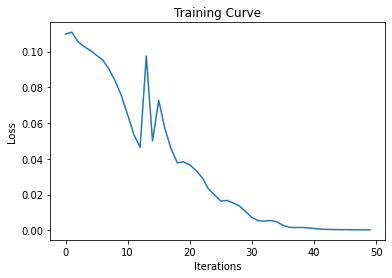

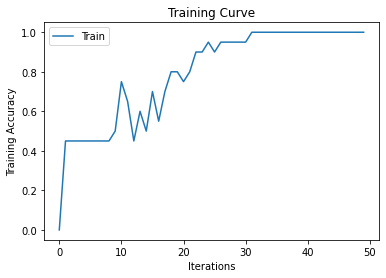

Final Training Accuracy: 1.0
Total run time for model_HandGestureClassifier_bs20_lr0.001_epoch50: 0:00:27.786701 (HH:MM:SS)


In [ ]:
use_cuda = True

model = HandGestureClassifier()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#proper model
train_small(model, learning_rate=0.001, batch_size=20, num_epochs=50)

### Part 3. Hyperparameter Search

### Part (a)

Tuning deep neural network hyperparameters is tough since deep neural networks are slow to train and have several parameters to customise.

* **Learning Rate:** The learning rate determines how frequently the weight in the 
optimization method is updated. Depending on the optimizer we employ (SGD, Adam, Adagrad, AdaDelta, or RMSProp), we can utilise a constant learning rate, a progressively declining learning rate, momentum-based approaches, or adaptive learning rates.

* **Number of Epochs:** The number of epochs is the number of times the full training set is processed by the neural network. We should increase the number of epochs until there is only a modest difference between the test and training errors.

* **Batch Size:** Mini-batch is frequently preferred in the convolutional neural network learning process. It should be noted that convnet is batch size sensitive.

* **Number of Hidden Layers and Units:** It's typically a good idea to keep adding layers until the test error no longer improves. The trade-off is that training the network is computationally costly. Having a minimal number of units may result in underfitting, although having more units is typically not hazardous with proper regularisation.

Here, I am selecting the batch size as my hyperparameters to keep my convolutional neural network model simple and computationally sound. I will tune the model with 64, 128, 256 batch sizes and keeping learning rate as 0.001 and number of epochs to 30(as there is no accuracy changes after 30 epochs).

CUDA is available!  Training on GPU ...
Epoch : 1, Train Accuracy: 0.27023319615912206, Test Accuracy: 0.25102880658436216, Model path: model_HandGestureClassifier_bs64_lr0.001_epoch1
Epoch : 2, Train Accuracy: 0.5665294924554184, Test Accuracy: 0.5596707818930041, Model path: model_HandGestureClassifier_bs64_lr0.001_epoch2
Epoch : 3, Train Accuracy: 0.6975308641975309, Test Accuracy: 0.6995884773662552, Model path: model_HandGestureClassifier_bs64_lr0.001_epoch3
Epoch : 4, Train Accuracy: 0.720164609053498, Test Accuracy: 0.7016460905349794, Model path: model_HandGestureClassifier_bs64_lr0.001_epoch4
Epoch : 5, Train Accuracy: 0.7229080932784636, Test Accuracy: 0.7037037037037037, Model path: model_HandGestureClassifier_bs64_lr0.001_epoch5
Epoch : 6, Train Accuracy: 0.7503429355281207, Test Accuracy: 0.7078189300411523, Model path: model_HandGestureClassifier_bs64_lr0.001_epoch6
Epoch : 7, Train Accuracy: 0.7777777777777778, Test Accuracy: 0.7386831275720165, Model path: model_HandGes

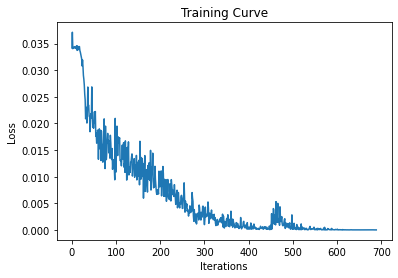

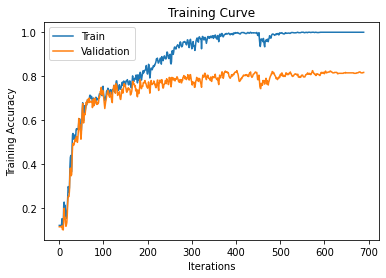

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.8168724279835391
Total run time for model_HandGestureClassifier_bs64_lr0.001_epoch30: 1:39:33.853132 (HH:MM:SS)


In [ ]:
torch.cuda.empty_cache()
use_cuda = True

model = HandGestureClassifier()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#proper model
train(model, learning_rate=0.001, batch_size=64, num_epochs=30)

CUDA is available!  Training on GPU ...
Epoch : 1, Train Accuracy: 0.3278463648834019, Test Accuracy: 0.2962962962962963, Model path: model_HandGestureClassifier_bs128_lr0.001_epoch1
Epoch : 2, Train Accuracy: 0.5281207133058985, Test Accuracy: 0.5432098765432098, Model path: model_HandGestureClassifier_bs128_lr0.001_epoch2
Epoch : 3, Train Accuracy: 0.6968449931412894, Test Accuracy: 0.6666666666666666, Model path: model_HandGestureClassifier_bs128_lr0.001_epoch3
Epoch : 4, Train Accuracy: 0.6947873799725651, Test Accuracy: 0.6872427983539094, Model path: model_HandGestureClassifier_bs128_lr0.001_epoch4
Epoch : 5, Train Accuracy: 0.7373113854595336, Test Accuracy: 0.6646090534979424, Model path: model_HandGestureClassifier_bs128_lr0.001_epoch5
Epoch : 6, Train Accuracy: 0.7722908093278463, Test Accuracy: 0.7222222222222222, Model path: model_HandGestureClassifier_bs128_lr0.001_epoch6
Epoch : 7, Train Accuracy: 0.789437585733882, Test Accuracy: 0.7263374485596708, Model path: model_Han

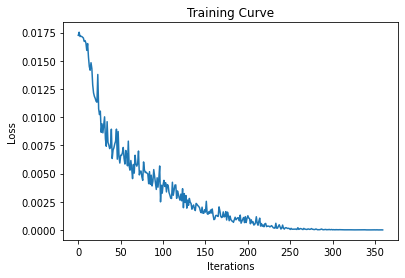

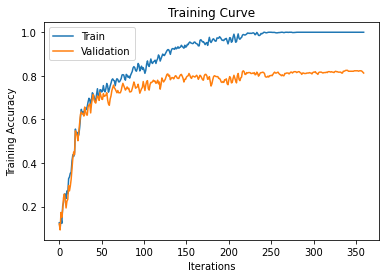

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.8127572016460906
Total run time for model_HandGestureClassifier_bs128_lr0.001_epoch30: 0:52:48.225107 (HH:MM:SS)


In [ ]:
torch.cuda.empty_cache()
use_cuda = True

model = HandGestureClassifier()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#proper model
train(model, learning_rate=0.001, batch_size=128, num_epochs=30)

CUDA is available!  Training on GPU ...
Epoch : 1, Train Accuracy: 0.30727023319615915, Test Accuracy: 0.28189300411522633, Model path: model_HandGestureClassifier_bs256_lr0.001_epoch1
Epoch : 2, Train Accuracy: 0.4993141289437586, Test Accuracy: 0.49382716049382713, Model path: model_HandGestureClassifier_bs256_lr0.001_epoch2
Epoch : 3, Train Accuracy: 0.6296296296296297, Test Accuracy: 0.6316872427983539, Model path: model_HandGestureClassifier_bs256_lr0.001_epoch3
Epoch : 4, Train Accuracy: 0.6474622770919067, Test Accuracy: 0.6584362139917695, Model path: model_HandGestureClassifier_bs256_lr0.001_epoch4
Epoch : 5, Train Accuracy: 0.7119341563786008, Test Accuracy: 0.6831275720164609, Model path: model_HandGestureClassifier_bs256_lr0.001_epoch5
Epoch : 6, Train Accuracy: 0.7517146776406035, Test Accuracy: 0.7325102880658436, Model path: model_HandGestureClassifier_bs256_lr0.001_epoch6
Epoch : 7, Train Accuracy: 0.757201646090535, Test Accuracy: 0.742798353909465, Model path: model_H

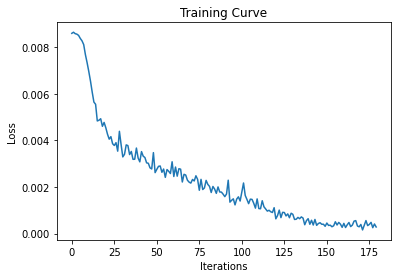

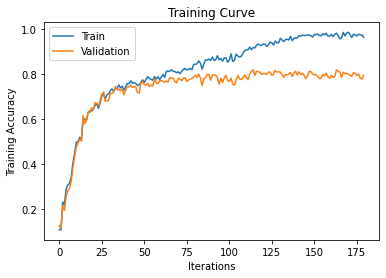

Final Training Accuracy: 0.9636488340192044
Final Validation Accuracy: 0.7942386831275721
Total run time for model_HandGestureClassifier_bs256_lr0.001_epoch30: 0:29:13.492289 (HH:MM:SS)


In [ ]:
torch.cuda.empty_cache()
use_cuda = True

model = HandGestureClassifier()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#proper model
train(model, learning_rate=0.001, batch_size=256, num_epochs=30)

From the above hyperparameter search, the best HandGestureClassifier model is with learning rate = 0.001, batch size = 64 and epoch = 21.
best model path = **model_HandGestureClassifier_bs64_lr0.001_epoch21**

### Part (b)
Reporting the test accuracy of your best model.

In [ ]:
torch.cuda.empty_cache()
use_cuda = True

model = HandGestureClassifier()
best_path = 'model_HandGestureClassifier_bs64_lr0.001_epoch21'

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
state = torch.load(best_path)
model.load_state_dict(state)

test_acc = get_accuracy(model, test_loader)
print('Test Accuracy on {}: {}'.format(best_path, test_acc))

CUDA is available!  Training on GPU ...
Test Accuracy on model_HandGestureClassifier_bs64_lr0.001_epoch21: 0.7802874743326489


### Part 4. Transfer Learning
For many image classification tasks, it is generally not a good idea to train a very large deep neural network
model from scratch due to the enormous compute requirements and lack of sufficient amounts of training
data.

One of the better options is to try using an existing model that performs a similar task to the one you need
to solve. This method of utilizing a pre-trained network for other similar tasks is broadly termed **Transfer
Learning**. In this project, I will use Transfer Learning to extract features from the hand gesture
images. Then, train a smaller network to use these features as input and classify the hand gestures.

### Part (a) Convert to Alexnet Features

In [ ]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

The alexnet model is split up into two components: *alexnet.features* and *alexnet.classifier*. The
first neural network component, *alexnet.features*, is used to compute convolutional features, which are
taken as input in *alexnet.classifier*.

The neural network alexnet.features expects an image tensor of shape Nx3x224x224 as input and it will
output a tensor of shape Nx256x6x6 . (N = batch size).

Computing the AlexNet features for each of training, validation, and test data.

In [ ]:
import os
train_loader, val_loader, test_loader = get_data(batch_size=1)

def convert_to_alexnet(loader, data_type):
  try:
    for i, data in enumerate(loader):

      img, label = data
      features = alexnet.features(img)
      tensor = torch.from_numpy(features.detach().numpy())
      tensor = tensor.squeeze(0)

      dir_name = 'alexnet_feats/'
      if not os.path.isdir(dir_name):
        os.mkdir(dir_name)

      folder = dir_name + data_type+'/'
      if not os.path.isdir(folder):
        os.mkdir(folder)

      sub_folder = folder + target_class[label]+ '/'
      if not os.path.isdir(sub_folder):
        os.mkdir(sub_folder)
      
      name = sub_folder + data_type +'_'+str(i)+'.pt'
      torch.save(tensor, name)

  except Exception as e:
    error_handling(e)

In [ ]:
convert_to_alexnet(train_loader, 'train')
convert_to_alexnet(test_loader, 'test')
convert_to_alexnet(val_loader, 'validation')

In [ ]:
train_path    = '/content/alexnet_feats/train'
train_data    = torchvision.datasets.DatasetFolder(train_path, loader=torch.load, extensions='.pt')

test_path = '/content/alexnet_feats/test'
test_data = torchvision.datasets.DatasetFolder(test_path, loader=torch.load, extensions='.pt')

val_path = '/content/alexnet_feats/validation'
val_data = torchvision.datasets.DatasetFolder(val_path, loader=torch.load, extensions='.pt')

def get_data_for_alexnet(batch_size):

  train_loader  = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=1, shuffle=True)
  val_loader    = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=1, shuffle=True)
  test_loader   = torch.utils.data.DataLoader(val_data, batch_size=batch_size, num_workers=1, shuffle=True)

  return train_loader, val_loader, test_loader

In [ ]:
#printing the shape of features and labels
train_loader, val_loader, test_loader = get_data_for_alexnet(batch_size=64)
dataiter = iter(train_loader)
features, labels = dataiter.next()
print(features.shape)
print(labels.shape)

torch.Size([64, 256, 6, 6])
torch.Size([64])


### Part (b) Model building
Building a convolutional neural network model that takes as input these AlexNet features, and makes a
prediction. The Convolutional network which I had created has one conventional layer and one max pooling layer as the inputs are already Alexnet features. after the convolution layer here I am using a linear layer with 9 classifications out channels. This model is simple than the previous model as we are using the transfer learning features from pre-trained alexnet features. I have chosen Relu as my activation function, similar to the previous model.

In [ ]:
#Convolutional Neural Network Architecture
class HandGestureClassifier_alexnet(nn.Module):
    def __init__(self):
        super(HandGestureClassifier_alexnet, self).__init__()
        try:
          self.name = 'HandGestureClassifier_alexnet'
          self.conv1 = nn.Conv2d(256, 128, 5) #in_channels, out_chanels, kernel_size
          self.pool1 = nn.MaxPool2d(2, 2) #kernel_size, stride 
          self.flat = nn.Flatten()
          self.fc1 = nn.Linear(128, 32)
          # self.fc2 = nn.Linear(32, 9)

        except Exception as e:
          error_handling(e)

    def forward(self, x):
        try:
          x = self.pool1(F.relu(self.conv1(x)))
          x = self.flat(x)
          #print(x.size()) #found in_features size by printing the size of flatten
          x = self.fc1(x)

        except Exception as e:
          error_handling(e)

        return x

### Part (c) Training with Hyperparameter tuning

In [ ]:
def train_with_alexnet(model, learning_rate=0.01, batch_size=64, num_epochs=20):
    
    try:
      start = datetime.now()
      criterion = nn.CrossEntropyLoss()
      optimizer = optim.Adam(model.parameters(), lr=learning_rate)

      train_loader, val_loader, test_loader = get_data_for_alexnet(batch_size=batch_size)

      iters, losses, train_acc, val_acc = [], [], [], []
      t_acc, v_acc = 0, 0

      # training
      n = 0 # the number of iterations
      for epoch in range(num_epochs):
          for imgs, labels in iter(train_loader):
            
            
              #############################################
              #To Enable GPU Usage
              if use_cuda and torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()
              #############################################
              
              out = model(imgs)             # forward pass
              loss = criterion(out, labels) # compute the total loss
              loss.backward()               # backward pass (compute parameter updates)
              optimizer.step()              # make the updates for each parameter
              optimizer.zero_grad()         # a clean up step for PyTorch

              # save the current training information
              iters.append(n)
              losses.append(float(loss)/batch_size)             # compute *average* loss
              t_acc = get_accuracy(model, train_loader)
              v_acc = get_accuracy(model, val_loader)
              train_acc.append(t_acc) # compute training accuracy 
              val_acc.append(v_acc)  # compute validation accuracy
              n += 1
          
          model_path = get_model_name(model.name, batch_size, learning_rate, epoch+1)
          torch.save(model.state_dict(), model_path)

          print(("Epoch : {}, Train Accuracy: {}, Test Accuracy: {}, Model path: {}").format(epoch+1, t_acc, v_acc, model_path))

      # plotting
      plt.title("Training Curve")
      plt.plot(iters, losses, label="Train")
      plt.xlabel("Iterations")
      plt.ylabel("Loss")
      plt.show()

      plt.title("Training Curve")
      plt.plot(iters, train_acc, label="Train")
      plt.plot(iters, val_acc, label="Validation")
      plt.xlabel("Iterations")
      plt.ylabel("Training Accuracy")
      plt.legend(loc='best')
      plt.show()

      print("Final Training Accuracy: {}".format(train_acc[-1]))
      print("Final Validation Accuracy: {}".format(val_acc[-1]))

      stop = datetime.now()
      runtime = stop - start
      print('Total run time for {}: {} (HH:MM:SS)'.format(model_path, runtime))

    except Exception as e:
          error_handling(e)
    

CUDA is not available.  Training on CPU ...
Epoch : 1, Train Accuracy: 0.8491083676268861, Test Accuracy: 0.7987679671457906, Model path: model_HandGestureClassifier_alexnet_bs64_lr0.001_epoch1
Epoch : 2, Train Accuracy: 0.9471879286694102, Test Accuracy: 0.891170431211499, Model path: model_HandGestureClassifier_alexnet_bs64_lr0.001_epoch2
Epoch : 3, Train Accuracy: 0.9766803840877915, Test Accuracy: 0.9055441478439425, Model path: model_HandGestureClassifier_alexnet_bs64_lr0.001_epoch3
Epoch : 4, Train Accuracy: 0.98559670781893, Test Accuracy: 0.919917864476386, Model path: model_HandGestureClassifier_alexnet_bs64_lr0.001_epoch4
Epoch : 5, Train Accuracy: 0.9917695473251029, Test Accuracy: 0.919917864476386, Model path: model_HandGestureClassifier_alexnet_bs64_lr0.001_epoch5
Epoch : 6, Train Accuracy: 0.9986282578875172, Test Accuracy: 0.9301848049281314, Model path: model_HandGestureClassifier_alexnet_bs64_lr0.001_epoch6
Epoch : 7, Train Accuracy: 0.9986282578875172, Test Accuracy:

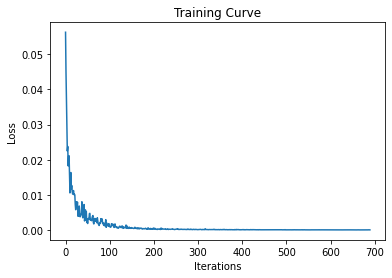

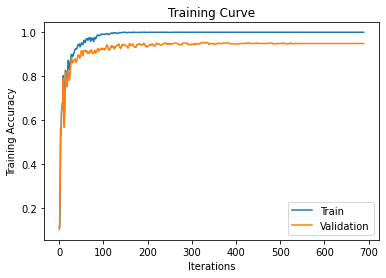

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.9486652977412731
Total run time for model_HandGestureClassifier_alexnet_bs64_lr0.001_epoch30: 0:11:55.013468 (HH:MM:SS)


In [ ]:
torch.cuda.empty_cache()
use_cuda = True

model = HandGestureClassifier_alexnet()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#proper model
train_with_alexnet(model, learning_rate=0.001, batch_size=64, num_epochs=30)

CUDA is not available.  Training on CPU ...
Epoch : 1, Train Accuracy: 0.8155006858710563, Test Accuracy: 0.8295687885010267, Model path: model_HandGestureClassifier_alexnet_bs128_lr0.001_epoch1
Epoch : 2, Train Accuracy: 0.8882030178326474, Test Accuracy: 0.8624229979466119, Model path: model_HandGestureClassifier_alexnet_bs128_lr0.001_epoch2
Epoch : 3, Train Accuracy: 0.9492455418381345, Test Accuracy: 0.9096509240246407, Model path: model_HandGestureClassifier_alexnet_bs128_lr0.001_epoch3
Epoch : 4, Train Accuracy: 0.9794238683127572, Test Accuracy: 0.9281314168377823, Model path: model_HandGestureClassifier_alexnet_bs128_lr0.001_epoch4
Epoch : 5, Train Accuracy: 0.99039780521262, Test Accuracy: 0.9342915811088296, Model path: model_HandGestureClassifier_alexnet_bs128_lr0.001_epoch5
Epoch : 6, Train Accuracy: 0.9958847736625515, Test Accuracy: 0.9342915811088296, Model path: model_HandGestureClassifier_alexnet_bs128_lr0.001_epoch6
Epoch : 7, Train Accuracy: 0.9979423868312757, Test 

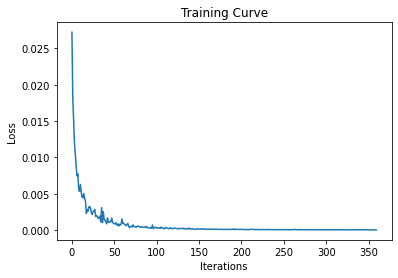

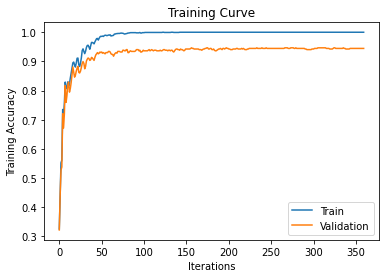

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.944558521560575
Total run time for model_HandGestureClassifier_alexnet_bs128_lr0.001_epoch30: 0:06:26.263889 (HH:MM:SS)


In [ ]:
torch.cuda.empty_cache()
use_cuda = True

model = HandGestureClassifier_alexnet()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#proper model
train_with_alexnet(model, learning_rate=0.001, batch_size=128, num_epochs=30)

CUDA is not available.  Training on CPU ...
Epoch : 1, Train Accuracy: 0.7379972565157751, Test Accuracy: 0.6714579055441479, Model path: model_HandGestureClassifier_alexnet_bs256_lr0.001_epoch1
Epoch : 2, Train Accuracy: 0.8689986282578875, Test Accuracy: 0.8316221765913757, Model path: model_HandGestureClassifier_alexnet_bs256_lr0.001_epoch2
Epoch : 3, Train Accuracy: 0.9053497942386831, Test Accuracy: 0.86652977412731, Model path: model_HandGestureClassifier_alexnet_bs256_lr0.001_epoch3
Epoch : 4, Train Accuracy: 0.9382716049382716, Test Accuracy: 0.8993839835728953, Model path: model_HandGestureClassifier_alexnet_bs256_lr0.001_epoch4
Epoch : 5, Train Accuracy: 0.9567901234567902, Test Accuracy: 0.9055441478439425, Model path: model_HandGestureClassifier_alexnet_bs256_lr0.001_epoch5
Epoch : 6, Train Accuracy: 0.9842249657064472, Test Accuracy: 0.9096509240246407, Model path: model_HandGestureClassifier_alexnet_bs256_lr0.001_epoch6
Epoch : 7, Train Accuracy: 0.9883401920438958, Test 

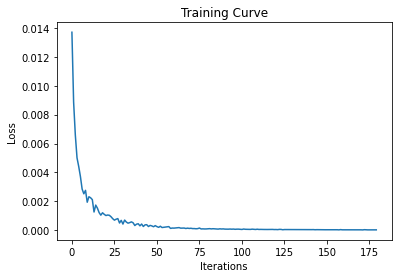

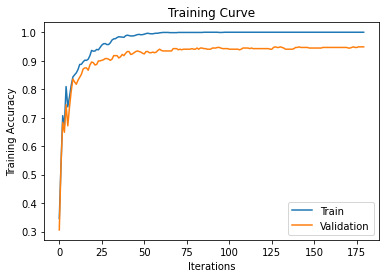

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.9486652977412731
Total run time for model_HandGestureClassifier_alexnet_bs256_lr0.001_epoch30: 0:03:46.432853 (HH:MM:SS)


In [ ]:
torch.cuda.empty_cache()
use_cuda = True

model = HandGestureClassifier_alexnet()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#proper model
train_with_alexnet(model, learning_rate=0.001, batch_size=256, num_epochs=30)

### Part (d) Best model on test data
From the above runs the best validation score is for model_HandGestureClassifier_alexnet_bs64_lr0.001_epoch21 with batch size=64, learning rate=0.01 and epoch=21. The test accuracy has been increased significantly from 78 percent to 94 percent after implementing transfer learning.

In [ ]:
torch.cuda.empty_cache()
use_cuda = True

model = HandGestureClassifier_alexnet()
best_path = 'model_HandGestureClassifier_alexnet_bs64_lr0.001_epoch21'

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
state = torch.load(best_path)
model.load_state_dict(state)

test_acc = get_accuracy(model, test_loader)
print('Test Accuracy on {}: {}'.format(best_path, test_acc))

CUDA is not available.  Training on CPU ...
Test Accuracy on model_HandGestureClassifier_alexnet_bs64_lr0.001_epoch21: 0.9499455930359086


### Part 5. Testing on New Data
As a final step in testing we will be verifying the model with hand images of my own hand and will be used to demonstrate how well your model works at identifying your hand guestures. 



### Part (a)
Loading and processing the hand gesture images to be evaulated by your model.

In [ ]:
my_hand_path = '/content/drive/MyDrive/Mukesh_Handdata'

transform = T.Compose([T.Resize((224,224)),T.ToTensor()])

my_hand_data = torchvision.datasets.ImageFolder(my_hand_path, transform=transform)
my_hand_loader  = torch.utils.data.DataLoader(my_hand_data, batch_size=32, num_workers=1, shuffle=True)

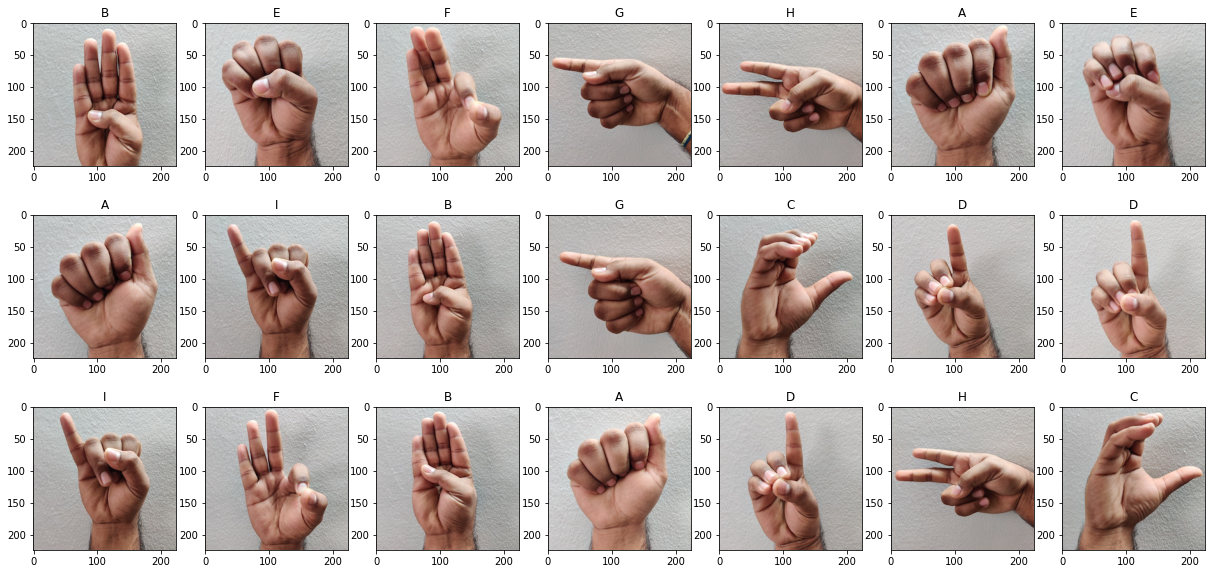

In [ ]:
#visualizing the 27 collected data samples
target_class = ['A','B','C','D','E','F','G','H','I']
dataiter = iter(my_hand_loader)
images, labels = dataiter.next()
images = images.numpy()

fig, ax = plt.subplots(nrows=3, ncols=7, figsize=(21,10))

i=0
for row in ax:
    for col in row:
        col.imshow(np.transpose(images[i], (1, 2, 0)))
        col.set_title(target_class[labels[i]])
        i = i+1

plt.show()

### Part (b)
The model performed better on its hand dataset(which I had provided) than the test and validation datasets. This might be due to unclear and non-centered images in the test and validation set. The images which I had collected are centered and properly cropped images, this has caused a high accuracy rate. But in real-world scenarios, the data is not processed properly and center cropped.

In [ ]:
#converting the original 224*224 pixels to Size of Alex net featuers
my_hand_loader  = torch.utils.data.DataLoader(my_hand_data, batch_size=1, num_workers=1, shuffle=True)
convert_to_alexnet(my_hand_loader, 'my_hand')
my_data_path = '/content/alexnet_feats/my_hand'
my_hand_data = torchvision.datasets.DatasetFolder(my_data_path, loader=torch.load, extensions='.pt')
my_hand_loader  = torch.utils.data.DataLoader(my_hand_data, batch_size=64, num_workers=1, shuffle=True)


dataiter = iter(my_hand_loader)
features, labels = dataiter.next()
print(features.shape)
print(labels.shape)

torch.Size([64, 256, 6, 6])
torch.Size([64])


In [ ]:
#model is loaded above
my_hand_data_acc = get_accuracy(model, my_hand_loader)
print('My Hand Data Accuracy on {}: {}'.format(best_path, my_hand_data_acc))

My Hand Data Accuracy on model_HandGestureClassifier_alexnet_bs64_lr0.001_epoch21: 1.0
